In [26]:
import pandas as pd
import numpy as np

In [27]:
WDIR = "/content/drive/MyDrive/projects/classical_machine_learning/malware_url_classification"

benign_df = pd.read_csv(f"{WDIR}/dataset/benign.csv", header=None, names=["URLs"])
malware_df = pd.read_csv(f"{WDIR}/dataset/malware.csv", header=None, names=["URLs"])

In [28]:
print("malware_df.shape: {} ".format(malware_df.shape))
print("benign_df.shape: {}".format(benign_df.shape))

malware_df.shape: (11566, 1) 
benign_df.shape: (35378, 1)


In [29]:
# malware URLs dataset
malware_df.head()

,URLs
0,http://gzzax.livechatvalue.com/chat/chatClient...
1,http://gzzax.livechatvalue.com/chat/chatClient...
2,http://gzzax.livechatvalue.com/chat/chatClient...
3,http://gzzax.livechatvalue.com/chat/chatClient...
4,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...


In [30]:
# benign URLs dataset
benign_df.head()

,URLs
0,http://1337x.to/torrent/1048648/American-Snipe...
1,http://1337x.to/torrent/1110018/Blackhat-2015-...
2,http://1337x.to/torrent/1122940/Blackhat-2015-...
3,http://1337x.to/torrent/1124395/Fast-and-Furio...
4,http://1337x.to/torrent/1145504/Avengers-Age-o...


## Feature Extraction

In [31]:
# install pyquery library

!pip install pyquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# script resource: https://towardsdatascience.com/extracting-feature-vectors-from-url-strings-for-malicious-url-detection-cbafc24737a

from pandas.core.arrays.numeric import T
from math import log
from re import compile
from urllib.parse import urlparse
from socket import gethostbyname
from pyquery import PyQuery
from requests import get
from json import dump
from string import ascii_lowercase
from numpy import array, log
from string import punctuation

class LexicalURLFeature:
    def __init__(self, url):
        self.description = 'blah'
        self.url = url
        self.urlparse = urlparse(self.url)
        # self.host = self.__get_ip()


    def __get_entropy(self, text):
        text = text.lower()
        probs = [text.count(c) / len(text) for c in set(text)]
        entropy = -sum([p * log(p) / log(2.0) for p in probs])
        return entropy

    def __get_ip(self):
        try:
            ip = self.urlparse.netloc if self.url_host_is_ip() else gethostbyname(self.urlparse.netloc)
            return ip
        except:
            return None

    # extract lexical features
    def url_scheme(self):
        return self.urlparse.scheme

    def url_length(self):
        return len(self.url)

    def url_path_length(self):
        return len(self.urlparse.path)

    def url_host_length(self):
        return len(self.urlparse.netloc)

    def url_host_is_ip(self):
        host = self.urlparse.netloc
        pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return match is not None

    def url_has_port_in_string(self):
        has_port = self.urlparse.netloc.split(':')
        return len(has_port) > 1 and has_port[-1].isdigit()

    def number_of_digits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def number_of_parameters(self):
        params = self.urlparse.query
        return 0 if params == '' else len(params.split('&'))

    def number_of_fragments(self):
        frags = self.urlparse.fragment
        return len(frags.split('#')) - 1 if frags == '' else 0

    def is_encoded(self):
        return '%' in self.url.lower()

    def num_encoded_char(self):
        encs = [i for i in self.url if i == '%']
        return len(encs)

    def url_string_entropy(self):
        return self.__get_entropy(self.url)

    def number_of_subdirectories(self):
        d = self.urlparse.path.split('/')
        return len(d)

    def number_of_periods(self):
        periods = [i for i in self.url if i == '.']
        return len(periods)

    def has_client_in_string(self):
        return 'client' in self.url.lower()

    def has_admin_in_string(self):
        return 'admin' in self.url.lower()

    def has_server_in_string(self):
        return 'server' in self.url.lower()

    def has_login_in_string(self):
        return 'login' in self.url.lower()
        
    def get_tld(self):
      return self.urlparse.netloc.split('.')[-1].split(':')[0]

In [33]:
## extract lexical features for benign and malware dataframes

def extract_lexical_features(df):
  samples = list()
  for url in df.values:
    sample = dict()
    feature_extractor = LexicalURLFeature(url[-1])
    sample["url"] = url
    sample["url_scheme"] = feature_extractor.url_scheme()
    sample["url_length"] = feature_extractor.url_length()
    sample["url_path_length"] = feature_extractor.url_path_length()
    sample["url_host_length"] = feature_extractor.url_host_length()
    sample["url_host_is_ip"] = feature_extractor.url_host_is_ip()
    sample["url_has_port_in_string"] = feature_extractor.url_has_port_in_string()
    sample["number_of_digits"] = feature_extractor.number_of_digits()
    sample["number_of_parameters"] = feature_extractor.number_of_parameters()
    sample["number_of_fragments"] = feature_extractor.number_of_fragments()
    sample["is_encoded"] = feature_extractor.is_encoded()
    sample["num_encoded_char"] = feature_extractor.num_encoded_char()
    sample["url_string_entropy"] = feature_extractor.url_string_entropy()
    sample["number_of_subdirectories"] = feature_extractor.number_of_subdirectories()
    sample["number_of_periods"] = feature_extractor.number_of_periods()
    sample["has_client_in_string"] = feature_extractor.has_client_in_string()
    sample["has_admin_in_string"] = feature_extractor.has_admin_in_string()
    sample["has_server_in_string"] = feature_extractor.has_server_in_string()
    sample["has_login_in_string"] = feature_extractor.has_login_in_string()
    sample["tld"] = feature_extractor.get_tld()
    samples.append(sample)
  return pd.DataFrame(samples)

# benign URLs lexical extracted features
b_lexical_features = extract_lexical_features(benign_df)

# malware URLs extracted lexical features
m_lexical_features = extract_lexical_features(malware_df)

In [34]:
from sklearn.utils import shuffle

# assigned numerical value for each class (0 = benign; 1 = malware)
b_lexical_features["class"] = 0
m_lexical_features["class"] = 1

# merged two dataframes
df = pd.concat([b_lexical_features, m_lexical_features], axis=0)
df = shuffle(df).reset_index(drop=True)
print("(merged dataframe) df.shape: {}".format(df.shape))

(merged dataframe) df.shape: (46944, 21)


In [35]:
# check first few records

df.head()

,url,url_scheme,url_length,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,number_of_fragments,...,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld,class
0,[http://yourlust.com/videos/chubby-dutch-honey...,http,93,74,12,False,False,0,0,0,...,0,4.244684,3,2,False,False,False,False,com,0
1,[http://chinesevie.com/index.php?option=com_co...,http,81,10,14,False,False,0,4,0,...,0,4.400942,2,2,False,False,False,True,com,1
2,[http://pantip.com/tag/%E0%B8%81%E0%B8%B2%E0%B...,http,118,101,10,False,False,31,0,0,...,26,3.992968,3,1,False,False,False,False,com,0
3,[http://codecanyon.net/item/global-gallery-ove...,http,93,72,14,False,False,8,0,0,...,0,4.588726,5,1,False,False,False,False,net,0
4,[http://thenextweb.com/facebook/2015/03/26/fac...,http,83,62,14,False,False,14,0,0,...,0,4.681722,7,2,False,False,False,False,com,0


In [36]:
# check dataframe information (column datatypes, # of missing values, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46944 entries, 0 to 46943
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46944 non-null  object 
 1   url_scheme                46944 non-null  object 
 2   url_length                46944 non-null  int64  
 3   url_path_length           46944 non-null  int64  
 4   url_host_length           46944 non-null  int64  
 5   url_host_is_ip            46944 non-null  bool   
 6   url_has_port_in_string    46944 non-null  bool   
 7   number_of_digits          46944 non-null  int64  
 8   number_of_parameters      46944 non-null  int64  
 9   number_of_fragments       46944 non-null  int64  
 10  is_encoded                46944 non-null  bool   
 11  num_encoded_char          46944 non-null  int64  
 12  url_string_entropy        46944 non-null  float64
 13  number_of_subdirectories  46944 non-null  int64  
 14  number

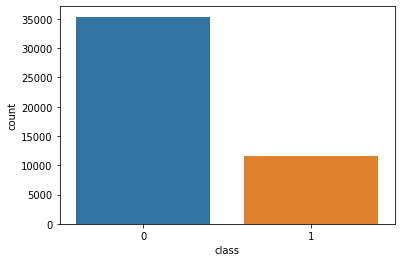

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# malware (1) v benign (0) URLs distribution
sns.countplot(data=df, x="class")

In [38]:
# replace True or False values by 1 and 0, respectively

mask = df.select_dtypes(include='bool').columns
df.loc[:, mask] = df.loc[:, mask].replace({True: 1, False: 0})
df

,url,url_scheme,url_length,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,number_of_parameters,number_of_fragments,...,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld,class
0,[http://yourlust.com/videos/chubby-dutch-honey...,http,93,74,12,0,0,0,0,0,...,0,4.244684,3,2,0,0,0,0,com,0
1,[http://chinesevie.com/index.php?option=com_co...,http,81,10,14,0,0,0,4,0,...,0,4.400942,2,2,0,0,0,1,com,1
2,[http://pantip.com/tag/%E0%B8%81%E0%B8%B2%E0%B...,http,118,101,10,0,0,31,0,0,...,26,3.992968,3,1,0,0,0,0,com,0
3,[http://codecanyon.net/item/global-gallery-ove...,http,93,72,14,0,0,8,0,0,...,0,4.588726,5,1,0,0,0,0,net,0
4,[http://thenextweb.com/facebook/2015/03/26/fac...,http,83,62,14,0,0,14,0,0,...,0,4.681722,7,2,0,0,0,0,com,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46939,[http://www.114633.com/app/member/BrowseSport/...,http,89,34,14,0,0,6,3,0,...,0,4.534338,5,3,0,0,0,0,com,1
46940,[http://grasslandhotel.com.vn/index.php/tours/...,http,72,44,21,0,0,0,0,0,...,0,4.387445,6,4,0,0,0,0,vn,1
46941,[http://windows.microsoft.com/en-us/internet-e...,http,77,49,21,0,0,1,0,0,...,0,4.335911,4,2,0,0,0,0,com,1
46942,[http://chinacxyy.com/newscodejs.asp?lm2=199&l...,http,170,15,13,0,0,25,19,0,...,0,4.554088,2,3,0,0,0,0,com,1


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46944 entries, 0 to 46943
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46944 non-null  object 
 1   url_scheme                46944 non-null  object 
 2   url_length                46944 non-null  int64  
 3   url_path_length           46944 non-null  int64  
 4   url_host_length           46944 non-null  int64  
 5   url_host_is_ip            46944 non-null  int64  
 6   url_has_port_in_string    46944 non-null  int64  
 7   number_of_digits          46944 non-null  int64  
 8   number_of_parameters      46944 non-null  int64  
 9   number_of_fragments       46944 non-null  int64  
 10  is_encoded                46944 non-null  int64  
 11  num_encoded_char          46944 non-null  int64  
 12  url_string_entropy        46944 non-null  float64
 13  number_of_subdirectories  46944 non-null  int64  
 14  number

In [40]:
# train-test-split
from sklearn.model_selection import train_test_split

X = df.drop(["url", "class"], axis=1)
y = df.loc[:, "class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))

X_train.shape: (37555, 19)
X_test.shape: (9389, 19)


In [41]:
y_train.value_counts(normalize=True)

0    0.753695
1    0.246305
Name: class, dtype: float64

In [42]:
y_test.value_counts(normalize=True)

0    0.753328
1    0.246672
Name: class, dtype: float64

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37555 entries, 41530 to 15795
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url_scheme                37555 non-null  object 
 1   url_length                37555 non-null  int64  
 2   url_path_length           37555 non-null  int64  
 3   url_host_length           37555 non-null  int64  
 4   url_host_is_ip            37555 non-null  int64  
 5   url_has_port_in_string    37555 non-null  int64  
 6   number_of_digits          37555 non-null  int64  
 7   number_of_parameters      37555 non-null  int64  
 8   number_of_fragments       37555 non-null  int64  
 9   is_encoded                37555 non-null  int64  
 10  num_encoded_char          37555 non-null  int64  
 11  url_string_entropy        37555 non-null  float64
 12  number_of_subdirectories  37555 non-null  int64  
 13  number_of_periods         37555 non-null  int64  
 14  ha

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# fetch numerical and categorical attributes, respectively
num_attribs = X_train.select_dtypes(include=[np.int64, np.float64]).columns
cat_attribs =  X_train.select_dtypes(include=[object]).columns

# transformation pipeline for numerical attributes
num_pipeline = Pipeline([
  ('minmax_scaler', MinMaxScaler()),
])

# full transformation pipeline for categorical and numerical attributes
full_pipeline = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
])

# transform both training and testing datasets
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [45]:
import sklearn
sklearn.__version__

'1.0.2'

In [46]:
X_test_prepared.shape

(9389, 72)

In [47]:
X_train_prepared.shape

(37555, 72)

In [48]:
import joblib
import os

joblib.dump(full_pipeline, os.path.join(WDIR, 'pipeline.pkl'))

['/content/drive/MyDrive/projects/classical_machine_learning/malware_url_classification/pipeline.pkl']

In [49]:
## DecisionTreeClassifier model
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train_prepared, y_train)

DecisionTreeClassifier(random_state=42)

In [50]:
# extract available ccp alphas for pruning

path = clf_dt.cost_complexity_pruning_path(X_train_prepared, y_train)
ccp_alphas = path.ccp_alphas[:-1]
print('Len of ccp_alphas: {}'.format(ccp_alphas.shape))

Len of ccp_alphas: (121,)


In [51]:
# apply grid search to find optimal value for ccp alpha

from sklearn.model_selection import GridSearchCV

param_grid = {'ccp_alpha': ccp_alphas}

grid_search = GridSearchCV(
    DecisionTreeClassifier(), param_grid, cv=10, scoring='balanced_accuracy')

grid_search.fit(X_train_prepared, y_train)

print("Best Parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best Parameters: {'ccp_alpha': 1.775025998451053e-05}
Best cross-validation score: 1.00


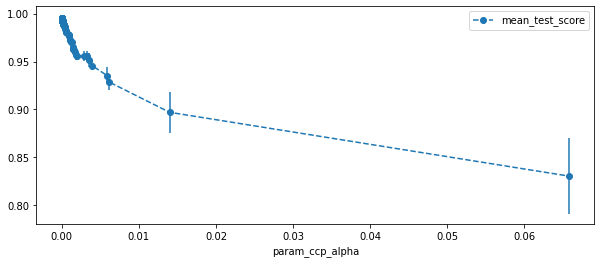

In [52]:
# plot results of grid search
results = pd.DataFrame(grid_search.cv_results_)
fig, ax = plt.subplots(figsize=(10, 4))
results.plot(x='param_ccp_alpha', y='mean_test_score', 
             yerr='std_test_score', marker='o', linestyle='--', ax=ax)

In [53]:
# train ideal decision tree 
ideal_ccp_alpha = grid_search.best_params_['ccp_alpha']

clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train_prepared, y_train)

DecisionTreeClassifier(ccp_alpha=1.775025998451053e-05, random_state=42)

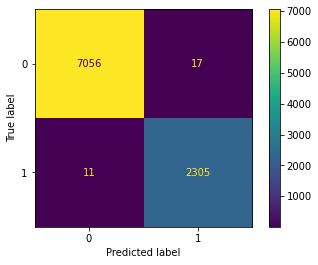

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

# make predictions on testing dataset
y_preds = clf_dt_pruned.predict(X_test_prepared)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

In [55]:
from sklearn.metrics import classification_report

# make classification report on testing dataset
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7073
           1       0.99      1.00      0.99      2316

    accuracy                           1.00      9389
   macro avg       1.00      1.00      1.00      9389
weighted avg       1.00      1.00      1.00      9389



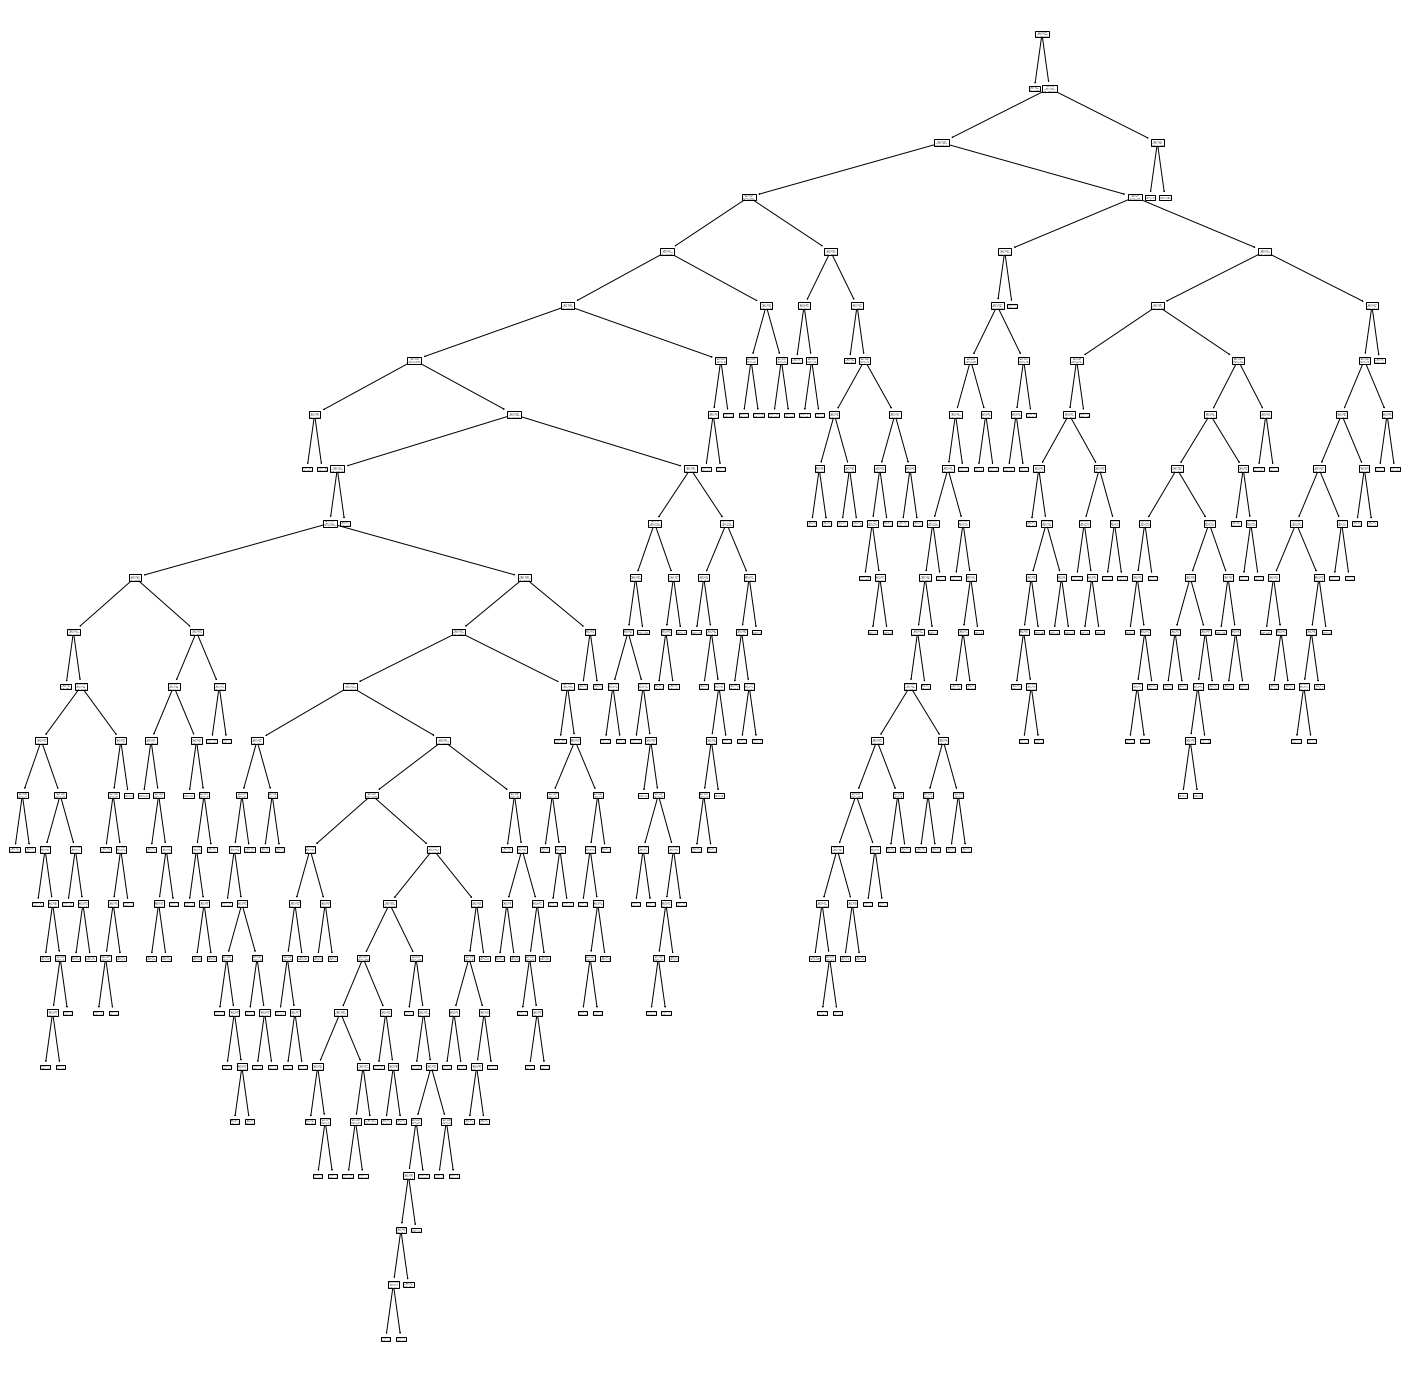

In [56]:
from sklearn import tree

# plot decision tree model
fig, ax = plt.subplots(figsize=(25, 25))
_ = tree.plot_tree(clf_dt_pruned, ax=ax)

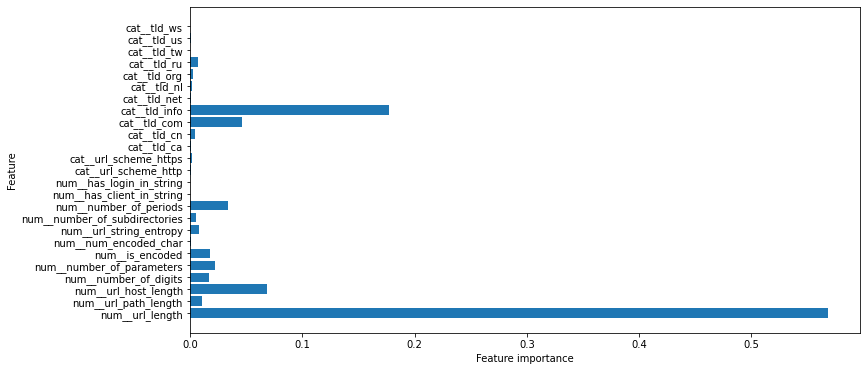

In [57]:
# plot feature importance

def plot_feature_importances_cancer(model):

 fig, ax = plt.subplots(figsize=(12, 6))
 mask = model.feature_importances_ > 0
 f_importance = model.feature_importances_[mask]
 features = full_pipeline.get_feature_names_out()[mask]
 n_features = len(features) 

 ax.barh(range(n_features), f_importance, align='center')
 plt.yticks(range(n_features), features)
 ax.set_xlabel("Feature importance")
 ax.set_ylabel("Feature")

plot_feature_importances_cancer(clf_dt_pruned)

In [58]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(clf_dt_pruned, f'{WDIR}/model.pkl')

['/content/drive/MyDrive/projects/classical_machine_learning/malware_url_classification/model.pkl']

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      7073
           1       0.93      0.78      0.85      2316

    accuracy                           0.93      9389
   macro avg       0.93      0.88      0.90      9389
weighted avg       0.93      0.93      0.93      9389



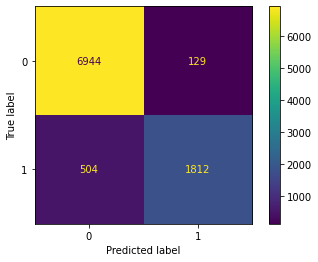

In [63]:
# make predictions on testing dataset
y_preds = logreg.predict(X_test_prepared)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

# make classification report on testing dataset
print(classification_report(y_test, y_preds))

In [64]:
# Save the model as a pickle in a file
joblib.dump(logreg, f'{WDIR}/logreg.pkl')

['/content/drive/MyDrive/projects/classical_machine_learning/malware_url_classification/logreg.pkl']